In [1]:
import cv2
import numpy as np
import os
import json
from tensorflow import keras
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D, Flatten

from keras.preprocessing.image import ImageDataGenerator

import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

In [2]:
#1. Mount Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
gdrive = "/content/gdrive/MyDrive/207_project_files"
#KP: You'll see a pop-up from google to sign-in and connect to your drive



Mounted at /content/gdrive


In [3]:
#2. Copy archive.zip to gdrive to /home
#gdrive = "/content/gdrive/MyDrive"
!cp $gdrive/archive.zip /home

In [4]:
!rm -rf /home/data

In [5]:
#3. Unzip archive.zip to /home/data/full
!mkdir -p /home/data/full
!unzip /home/archive.zip -d /home/data/full/ > /dev/null

In [6]:
!mv /home/data/full/Driver\ Drowsiness\ Dataset\ \(DDD\) /home/data/train

!mv /home/data/train/Non\ Drowsy  /home/data/train/NonDrowsy

In [7]:
!ls /home/data/train/Drowsy | tail

ZC1349.png
ZC1350.png
ZC1351.png
ZC1352.png
ZC1353.png
ZC1354.png
ZC1355.png
ZC1356.png
ZC1357.png
ZC1358.png


In [8]:
!ls /home/data/train/NonDrowsy | tail

zc1697.png
zc1698.png
zc1699.png
zc1700.png
zc1702.png
zc1703.png
zc1704.png
zc1705.png
zc1706.png
zc1707.png


In [9]:
import os
import csv
import random
import string

def randomize_file_names (dir_path, mapping_file_name):


  # create a list of all the files in the directory
  files = os.listdir(dir_path)

  # create a dictionary to store the old and new file names
  file_mapping = {}

  # loop through each file in the directory
  for file in files:
      # generate a random string of 10 characters
      new_name = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10))
      # get the file extension
      ext = os.path.splitext(file)[1]
      # create the new file name with the random string and the original file extension
      new_file_name = new_name + ext
      # rename the file
      os.rename(os.path.join(dir_path, file), os.path.join(dir_path, new_file_name))
      # add the old and new file names to the dictionary
      file_mapping[file] = new_file_name

  # write the file mapping to a csv file
  with open(mapping_file_name, 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerow(['Old Name', 'New Name'])
      for key, value in file_mapping.items():
          writer.writerow([key, value])

randomize_file_names ("/home/data/train/NonDrowsy/", 'file_mapping_NonDrowsy.csv')
randomize_file_names ("/home/data/train/Drowsy/", 'file_mapping_Drowsy.csv')



In [10]:
!rm -rf /home/data/test/Drowsy
!rm -rf /home/data/test/NonDrowsy

!mkdir -p /home/data/test/Drowsy
!mkdir -p /home/data/test/NonDrowsy




In [11]:
import os
import random
import shutil

def split_test(percent, src_dir, dst_dir):

  # get a list of all the image files in the source directory
  image_files = [f for f in os.listdir(src_dir) if f.endswith('.jpg') or f.endswith('.png')]

  # calculate the number of images to move
  num_images_to_move = int(len(image_files) * percent)

  # randomly select the images to move
  images_to_move = random.sample(image_files, num_images_to_move)

  # move the selected images to the destination directory
  for image in images_to_move:
      src_path = os.path.join(src_dir, image)
      dst_path = os.path.join(dst_dir, image)
      shutil.move(src_path, dst_path)

split_test(0.3, '/home/data/train/Drowsy', '/home/data/test/Drowsy')
split_test(0.3, '/home/data/train/NonDrowsy', '/home/data/test/NonDrowsy')

In [12]:
!ls /home/data/test/Drowsy | tail

ZYEE60ON96.png
ZYHNOB0EQU.png
ZYZE9RC95H.png
ZZ9DS3LTJU.png
ZZDRKXPOT0.png
ZZFVMTPTC6.png
ZZL38JE2WJ.png
ZZQHITJQGI.png
ZZUF16AHN1.png
ZZUM9FS92B.png


In [13]:
!ls /home/data/test/NonDrowsy | tail

ZWYXYGPY6D.png
ZXEYOOVMXQ.png
ZXQAYF9IBR.png
ZZ5VV5NJZT.png
ZZB9XJW87V.png
ZZKSON3OFE.png
ZZP965EXK1.png
ZZP98JWO6P.png
ZZU259ZFYL.png
ZZZKVI5UPP.png


In [14]:
#base_dir = root_dir + '207_project_files/data/'

In [15]:
#!unzip '/content/gdrive/MyDrive/207_project_files/data/Driver Drowsiness Dataset (DDD).zip' -d '/content/gdrive/MyDrive/207_project_files/data/full/'

In [16]:
#1. Mount gdrive

#2. Copy archive.zip to gdrive to /home
#3. Unzip archive.zip to /home/data/full
#4. Rename the full to train
#5. Randomize file names
#6. Move 30 percent files to test directory






# CNN Model

In [17]:
import cv2
import numpy as np
import os
import json
from tensorflow import keras
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D, Flatten

from keras.preprocessing.image import ImageDataGenerator

import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

In [18]:
import matplotlib.pyplot as plt

# create empty lists to store loss and epoch values
train_loss = []
val_loss = []
epochs = []

# KP: consider adding plots for accuracy
# define a function to update the plot
def update_plot(epoch, train_loss_value, val_loss_value):
    epochs.append(epoch)
    train_loss.append(train_loss_value)
    val_loss.append(val_loss_value)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# define a callback to update the plot after every epoch
class PlotLossCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        update_plot(epoch, logs['loss'], logs['val_loss'])



In [19]:
# Why the selectin of 32x32, but not something which has higher resolution
# Understood, this is comes from target_size=( in ImageDataGenerator
# checked current image size i 227 x 227
# kept original image size
X_RES = 227
Y_RES = 227

In [20]:
def build_model(train_model=True, kernel_size=(3, 3), activation='relu',
                strides=(1, 1), pool_size=(2, 2), drop_out=True, drop_rate=0.2):

    # Good choice to clear backend and set seeds
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = keras.Sequential()


    # refactor and use named parameter so easier to reference for experiments
    model.add(Conv2D(
        filters=32,                       # should we decrease number of filters
        kernel_size=kernel_size,               # Why not use 5,5 instead of 3,3
        strides=strides,                   # should we consider bigger stride?
        #input_shape=(Y_RES, X_RES, 3),   # Why is this utilized here, should be in build phase
                                          # 3 is batch size
        input_shape=(Y_RES, X_RES, 3),
        padding='same',                  # valid means no padding, need same
        #data_format='channels_last'      # should we add this? this appears to be default
        name='conv_1',
        activation=activation))

    # Pooling max pooling will reduce dimensions by half
    model.add(MaxPooling2D(
        pool_size=pool_size,
        name='pool_1'))

    # Nice idea to add in dropout to make network redudant but may reduce overall efficiency
    # Dropout layer 2nd - sould really change the name to
    if drop_out:
        model.add(Dropout(drop_rate)) # Why so many dropout, is this needed?

    # Second convulation layer
    model.add(Conv2D(
        filters=64,                       # Not sure why we need 64, not 32 layers here
        kernel_size=kernel_size,               # parameterized this
        name='conv_2',
        activation=activation))

    # Second pool layer, will reduce dimension by half
    model.add(MaxPooling2D(
        pool_size=pool_size,
        name='pool_2'))

    # Dropout layer 2nd
    if drop_out:
        model.add(Dropout(drop_rate))

    # # Third convolution layer
    # # a third layer?
    model.add(Conv2D(
        filters=128,                      # Not sure why we increase to 128 here
        kernel_size=kernel_size,
        name='conv_3',
        activation=activation))


    model.add(MaxPooling2D(
        pool_size=pool_size,
        name='pool_3'))

    # # Dropout layer - 3rd -- should these drop out be added after flatten and dense layer?
    if drop_out:
        model.add(Dropout(drop_rate))


    # Flatten Layer
    model.add(Flatten())

    # Dense layer - Fully connected layer
    # Not sure why we need so many Dense layers?
    # We should just get a units=1, single output for binary classification problem
    # Activiation here, should be None?

    # KP tryin out few dense layers:

    # Dense layer 1
    model.add(Dense(
        units=384,          # Changed to 1024 from 384
        name='dense_1',
        activation=activation,))  # Consider changing to None

    # Dense layer 2          # Why the additional two layers
    model.add(Dense(
        units=128,
        name='dense_2',
        activation=activation))

    # Dense layer 3          # Why the additional two layers
    model.add(Dense(
        units=32,
        name='dense_3',
        activation=activation))



    # # Dense layer 4
    # # Do we really need softmax, that's for multi class into probablities
    # model.add(Dense(
    #     units=2,
    #     name='dense_4',
    #     activation='softmax'))  # Consider activiation here to None
    #                                     # Use bincrosentropy and from_logits=True

    # Dense layer 4
    # Do we really need softmax, that's for multi class into probablities
    model.add(Dense(
        units=1,
        name='dense_4',
        # activation='softmax'))  # Consider activiation here to None
        activation=None))
                                        # Use bincrosentropy and from_logits=True


    ## added build phase here, added None for units in beginning
    # model.build(input_shape=(None, Y_RES, X_RES, 3))  # should be X_RES and then Y_RES

    # Reverting back to old style
    # model = model.build(train_model=train_model, drop_out=drop_out,
    #                     drop_rate=drop_rate)

    # Moving compile out
    return model

In [26]:
def compile_model(model, optimizer='Adagrad', loss='binary_crossentropy',
                  learn_rate=0.8, logits=True): # why not binary crossentropy

    # refactored optimizer and lr usage changed to learning_rate (keras warning on deprecation)
    if optimizer == 'Adagrad':
      opt = keras.optimizers.Adagrad(learning_rate=learn_rate)

    if optimizer == 'Adam':
      opt = keras.optimizers.Adam(learning_rate=learn_rate)

    if loss == 'binary_crossentropy':
      ls = tf.keras.losses.BinaryCrossentropy(from_logits=logits)
    if loss == 'categorical_crossentropy':
      ls = tf.keras.losses.CategoricalCrossentropy(from_logits=logits)

    # model.compile(loss=loss,
    #           optimizer=opt,
    #           metrics=['accuracy'])

    # KP: Tryin another compile loss method:
    model.compile(optimizer=opt,
              loss=ls, #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy'])

In [27]:
# refactored build model, set train_model = False, earlier True, changed name to drop_out
model = build_model(drop_out=True, drop_rate=0.2)
model.summary()

# Moved out compile to another cell

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 227, 227, 32)      896       
                                                                 
 pool_1 (MaxPooling2D)       (None, 113, 113, 32)      0         
                                                                 
 dropout (Dropout)           (None, 113, 113, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 111, 111, 64)      18496     
                                                                 
 pool_2 (MaxPooling2D)       (None, 55, 55, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 55, 55, 64)        0         
                                                                 
 conv_3 (Conv2D)             (None, 53, 53, 128)       7

In [28]:
# Compile Model
compile_model(model, optimizer='Adagrad', loss='binary_crossentropy', # using binary_crossentropy over categorical_crossentropy
                  learn_rate=0.8, logits=True)

In [29]:
train_dir = '/home/data/train/'


# What is the purpose of this ImageDataGenerator?
# This probably is not need in baseline model?
# Why batch size of 16?

batch_size = 16                      # Changed batch size to 100 from 16

train_datagen = ImageDataGenerator(
            #rescale=1.0, #/ 255,  # Rescale pixel values to [0, 1]
            # Disabling all these for time being:
            # rotation_range=5,  # Rotate images by up to 20 degrees
            # width_shift_range=0.2,  # Shift the width of the image by up to 20%
            # height_shift_range=0.2,  # Shift the height of the image by up to 20%
            # shear_range=0.2,  # Apply shear transformation
            # zoom_range=0.2,  # Zoom in by up to 20%
            # horizontal_flip=False,  # Flip images horizontally

            # fill_mode='nearest',  # Fill in missing pixels with the nearest value # removing this as we have same size image
            validation_split=0.3
        )



train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(X_RES, Y_RES),
    batch_size=batch_size,
    class_mode='binary',                 # why not binary? here categorical
    subset='training',
    shuffle=True,
    color_mode='rgb'                          # does color scale matter?

)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(X_RES, Y_RES),
    batch_size=batch_size,
    class_mode='binary',                 # why not binary? here categorical
    subset='validation',
    shuffle=True,
    color_mode='rgb'

)

Found 20480 images belonging to 2 classes.
Found 8776 images belonging to 2 classes.


Epoch 1/40
1280/1280 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5347

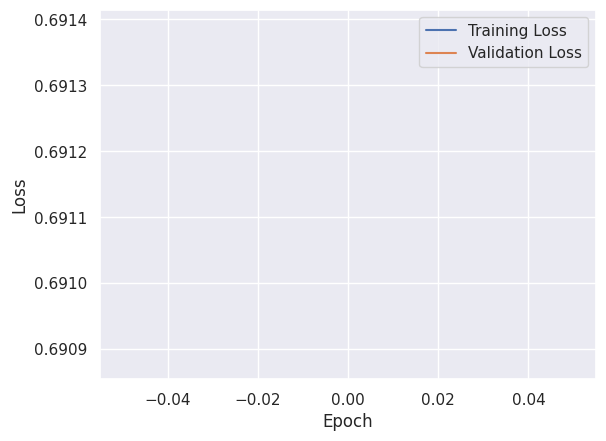

1280/1280 [==============================] - 155s 121ms/step - loss: 0.6914 - accuracy: 0.5347 - val_loss: 0.6909 - val_accuracy: 0.5349
Epoch 2/40
1280/1280 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.5347

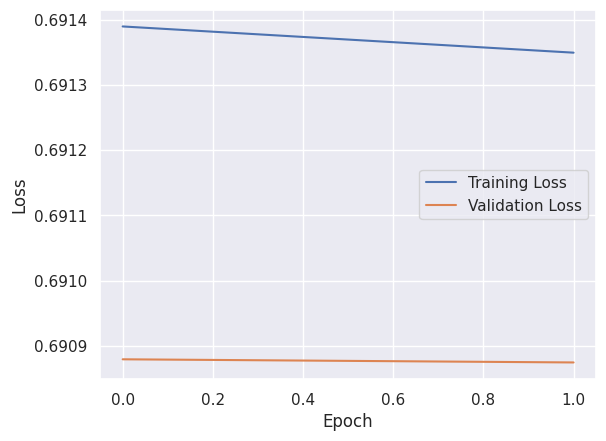

1280/1280 [==============================] - 139s 109ms/step - loss: 0.6913 - accuracy: 0.5347 - val_loss: 0.6909 - val_accuracy: 0.5346
Epoch 3/40
1280/1280 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.5347

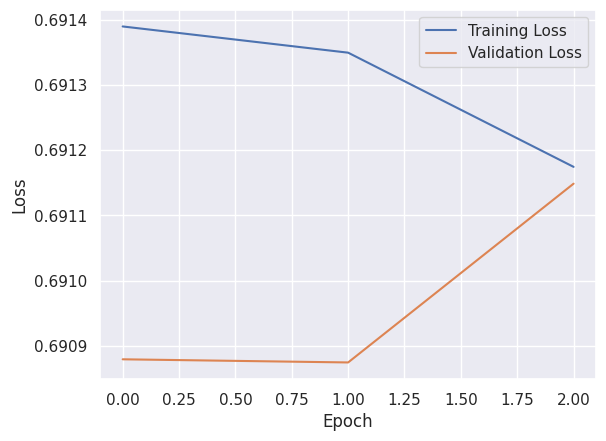

1280/1280 [==============================] - 123s 96ms/step - loss: 0.6912 - accuracy: 0.5347 - val_loss: 0.6911 - val_accuracy: 0.5347
Epoch 4/40
1280/1280 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.5347

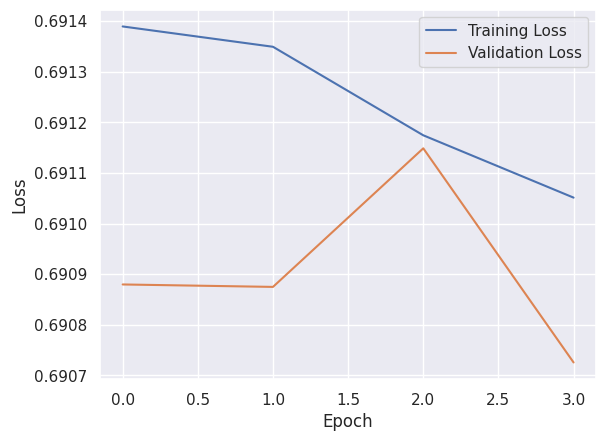

1280/1280 [==============================] - 123s 96ms/step - loss: 0.6911 - accuracy: 0.5347 - val_loss: 0.6907 - val_accuracy: 0.5348
Epoch 5/40
1280/1280 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5347

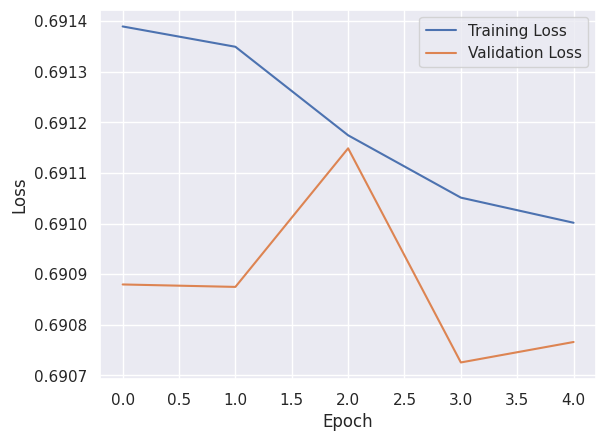

1280/1280 [==============================] - 123s 96ms/step - loss: 0.6910 - accuracy: 0.5347 - val_loss: 0.6908 - val_accuracy: 0.5348
Epoch 6/40
1280/1280 [==============================] - ETA: 0s - loss: 3.3680 - accuracy: 0.5347

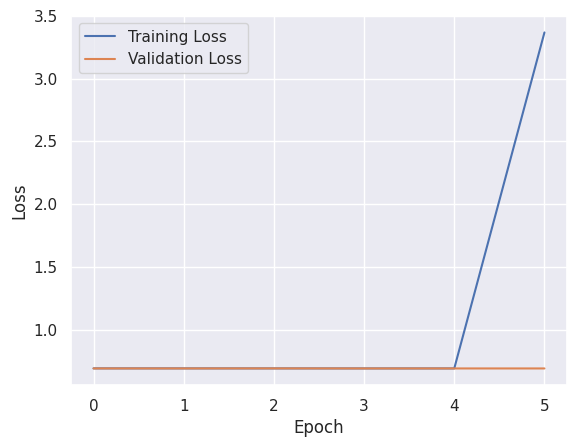

1280/1280 [==============================] - 124s 97ms/step - loss: 3.3680 - accuracy: 0.5347 - val_loss: 0.6907 - val_accuracy: 0.5348
Epoch 7/40
1280/1280 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5347

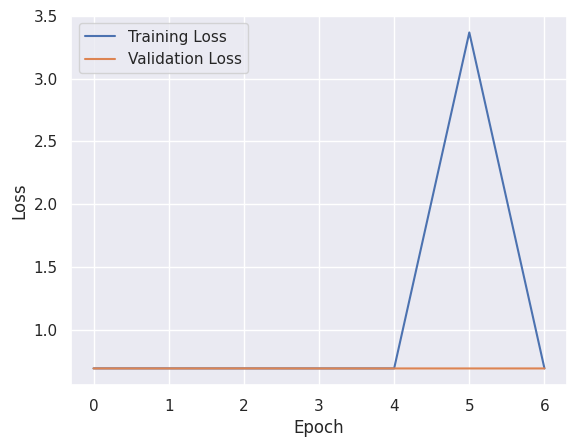

1280/1280 [==============================] - 126s 98ms/step - loss: 0.6910 - accuracy: 0.5347 - val_loss: 0.6908 - val_accuracy: 0.5344
Epoch 8/40
1280/1280 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.5347

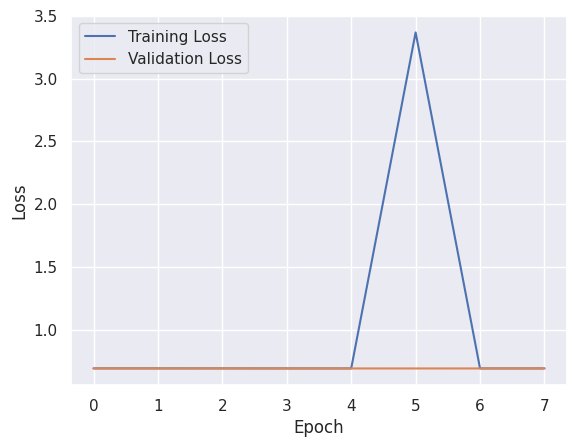

1280/1280 [==============================] - 124s 97ms/step - loss: 0.6908 - accuracy: 0.5347 - val_loss: 0.6913 - val_accuracy: 0.5349
Epoch 9/40
1280/1280 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5347

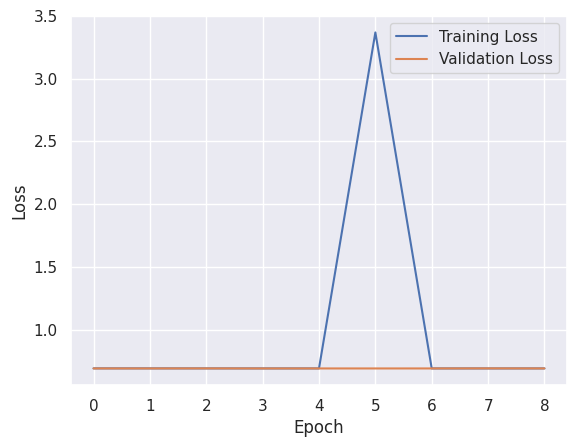

1280/1280 [==============================] - 126s 99ms/step - loss: 0.6910 - accuracy: 0.5347 - val_loss: 0.6909 - val_accuracy: 0.5349


In [33]:
# We have not learned about earlystopping, why use?
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# This Model fit using train_generator, might be over kill
# for baseline model build out
# Where is the validation generator sample?

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=40,                                                  # Reducing echos from 20 to 10
    callbacks=[PlotLossCallback(), early_stopping])

# KP: noticed this too long to run...

In [ ]:
model.save('/home/dd_model.h5')

In [ ]:
test_dir = '/home/data/test/'

test_datagen = ImageDataGenerator(
            #srescale=1.0 / 255,  # Rescale pixel values to [0, 1]
        )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(X_RES, Y_RES),
    class_mode='categorical',
    shuffle=True,
    batch_size=batch_size,
    color_mode='rgb'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

In [ ]:
#model = keras.models.load_model('dd_model.h5')

# This section is to test custom images

In [ ]:
# import  pandas as pd
# from IPython.display import display

# #dir_path = '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/'

# dir_path = '/Users/mayank/Programs/mids_ml/mids/DriverDrowsiness/data/test_img/'

# def predict(model, img):
#     img= keras.utils.load_img(
#         img, target_size=(X_RES, Y_RES), color_mode='rgb')
#     img_array = keras.utils.img_to_array(img)
#     img_array = img_array / 255.0
#     img_array = tf.expand_dims(img_array, 0)  # Create batch axis
#     predictions = model.predict(img_array)

#     return predictions

# i = 0
# prediction_results = []
# for file_name in os.listdir(dir_path):

#     predictions = predict(model, dir_path+file_name)

#     dp, fn = os.path.split(dir_path)
#     prediction_results.append([os.path.basename(dp)+'/'+file_name, predictions[0][0], predictions[0][1]])
#     i = i + 1
#     if i == 100:
#         break

# df = pd.DataFrame(prediction_results, columns=['Filename', 'Drowsy', 'Non-Drowsy'])

# #df = pd.DataFrame(prediction_results, columns=['Filename', '1', '2', '3', '4'])


# display(df)

In [ ]:
# import matplotlib.pyplot as plt

# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from keras.layers import Conv2D
# from keras.models import Model
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress most warnings

# import tensorflow as tf
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Suppress TensorFlow v1.x warnings


# def plot_conv_layers(model, img_path):
#     # Load the image
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (X_RES, Y_RES))
#     img = np.expand_dims(img, axis=0)  # Expand dimensions to match model's input shape

#     # Get the output of each Conv2D layer
#     layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
#     activation_model = Model(inputs=model.input, outputs=layer_outputs)

#     # Get activations
#     activations = activation_model.predict(img)
#     layer_names = [layer.name for layer in model.layers if isinstance(layer, Conv2D)]

#    # Plot the output of each layer in a 1x3 grid
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#     for i, ax in enumerate(axes):
#         ax.imshow(activations[i][0, :, :, 0], cmap='gray')  # Displaying the 1st channel
#         ax.set_title(layer_names[i])
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()


# # Plot the convolved layers
# plot_conv_layers(model, '/home/mayank/Pictures/Webcam/test/face_2.jpg')

# plot_conv_layers(model, '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/d0016.png')

# plot_conv_layers(model, '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/c0417.png')

# plot_conv_layers(model, '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/b0027.png')

# plot_conv_layers(model, '/home/mayank/programs/mids/DriverDrowsiness/data/test/NonDrowsy/a1023.png')